In [2]:
#Import packages
import arcpy
from pathlib import Path

# Set paths
raw_folder_path = Path.cwd().parent / 'data' / 'raw'
processed_folder_path = Path.cwd().parent / 'data' / 'processed'

#Allow arcpy to overwrite output
arcpy.env.overwriteOutput = True

#Set the default & scratch workspaces
arcpy.env.workspace = str(raw_folder_path)

In [3]:
# Set storm variable
storm_season = 2005
storm_name = "KATRINA"

# Set model outputs
storm_track_points = "memory/track_points"
storm_track="memory/Tracklines"
usa_counties = 'https://services.arcgis.com/P3ePLMYs2RVChkJx/arcgis/rest/services/USA_Counties_Generalized_Boundaries/FeatureServer/0'
affected_counties = processed_folder_path / 'affected_counties.shp'

In [4]:
# Select track points corresponding to a single storm
arcpy.analysis.Select(
    in_features="IBTrACS_NA.shp",
    out_feature_class=storm_track_points,
    where_clause=f"SEASON = {storm_season} And NAME = '{storm_name}'"
)

<Result 'memory\\track_points'>

In [5]:
# show the count of storm points
arcpy.management.GetCount(in_rows = storm_track_points)

<Result '64'>

In [6]:
inFeatures = storm_track_points
outFeatures = storm_track


arcpy.management.PointsToLine(
    inFeatures,
    outFeatures,
)

<Result 'memory\\Tracklines'>

In [7]:
arcpy.management.GetCount(in_rows = storm_track)

<Result '1'>

In [8]:
#Process: Select by location
select_result = arcpy.management.SelectLayerByLocation(
        in_layer=usa_counties,
        select_features=storm_track
	)
selected_counties_lyr = select_result.getOutput(0)

In [9]:
select_result.getOutput(0)

In [10]:
arcpy.management.GetCount(in_rows = selected_counties_lyr)

<Result '51'>

In [11]:
#Process: Copy features to shapefile
arcpy.management.CopyFeatures(
    in_features = select_result,
    out_feature_class = str(affected_counties)
)

<Result 'v:\\Rahhh\\data\\processed\\affected_counties.shp'>

In [17]:
#Import the arcgis package
import arcgis
  
#Create a "gis" object
gis = arcgis.GIS()
  
#Create a map
my_map = gis.map()
  
#Set the basemap to oceans
my_map.basemap.basemap = "oceans"
  
#Create feature layers from the storm tracks affected_counties path
track_lyr = arcgis.GeoAccessor.from_featureclass(storm_track)
counties_lyr = arcgis.GeoAccessor.from_featureclass(str(affected_counties))
  
#Add the affected counties as a layer to the map
my_map.content.add(counties_lyr)
my_map.content.add(track_lyr)
  
#Show the map
my_map.export_to_html('my_map.html')

True

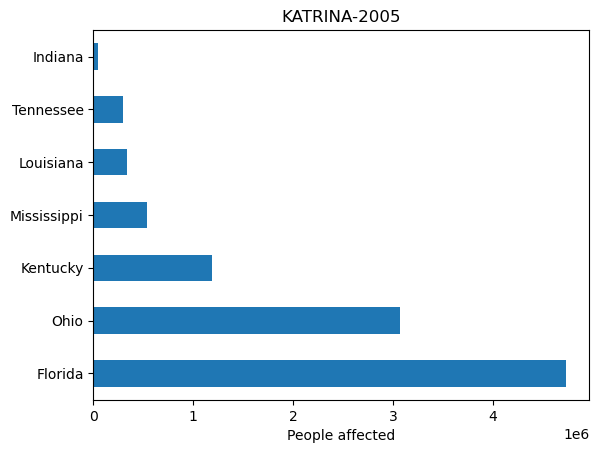

In [13]:
#Create a plot of people affected by state
the_plot = (
    counties_lyr.
    groupby('STATE_NAME')
    .agg({'POPULATION':'sum'})
    .sort_values(by='POPULATION',ascending=False)
    .plot(
        kind='barh',
        title=f'{storm_name}-{storm_season}',
        legend=False,
        xlabel='People affected',
        ylabel=''
        )
)